# TASK 2
#### forecast =[27576.018838 ,27249.936225 ,28224.674555 ,27606.064089 ,27087.487960 ,26641.752413 ,27335.482362]

I haven't used brute force gridsearch or pmdarima as I believe that would defeat the purpose of the exercise
From experience, when determining the parameters via PACF/ACF its worth to check out parameters around the obvious ones. For example if the acf suggest MA = 1 it's worth to check how model behaves on 0 na 2 as well. I didn't go for that approach here too as it falls into 'guessing' category.

To evaluate quality of fit I didn't use metrics like AIC as I wasn't concern with complexity of the model. MSE was chosen as simple way to evaluate plus it allowed to account for cases when model didn't fit correctly on substential spikes (or produced big spike when there was't one.


There is uils clas ForecstMaker in help_utils module (sorry not the most clean code) and the source code with the approaches attended are below.

Best approach is marked with (BEST)

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
from  datetime import datetime
import warnings
from help_utils import ForecastMaker
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#initiate the class and get the data for task two

fm = ForecastMaker()
df= fm.get_data_ex_two()

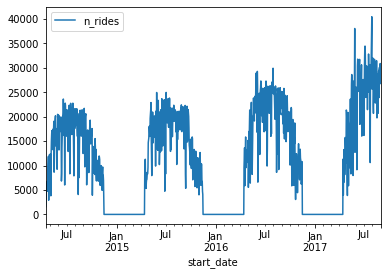

In [3]:
# yearly seasonality
df.plot()

Data is not stationary, p value is 0.4984430578191525
None


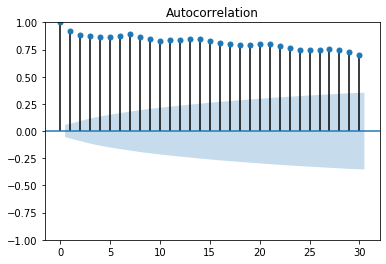

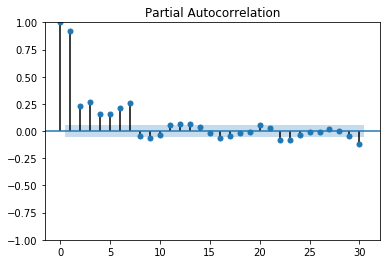

In [4]:
#can observe weekly seasonality
# adfuller's returned p value suggests data is not stationary

plot_acf(df["n_rides"],lags=30);
plot_pacf(df,lags=30);
print (fm.is_stationary(df["n_rides"]))

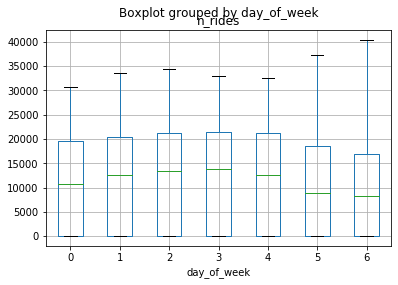

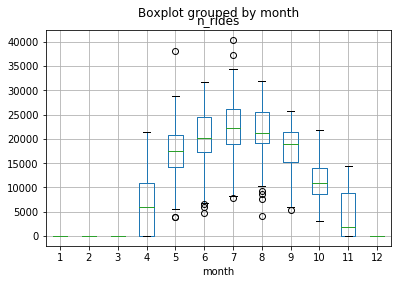

In [5]:
#check for assumtion that ther is weekly seasonality. seasonal effect can be seen there
df["day_of_week"] = df.index.dayofweek
df.boxplot(column='n_rides',by='day_of_week')
del df["day_of_week"]

#check for assumtion that there is yearly seasonality. strong effect
df["month"] = df.index.month
df.boxplot(column='n_rides',by='month')
del df["month"]

In [6]:
df["n_rides"] = df["n_rides"].diff()
df.dropna(inplace=True)
fm.is_stationary(df["n_rides"])

Data is stationary, p value is 2.8774971582739848e-11


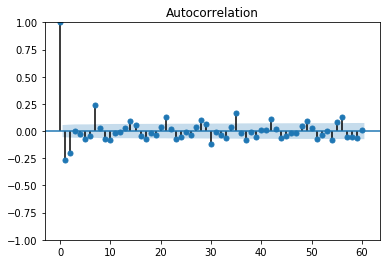

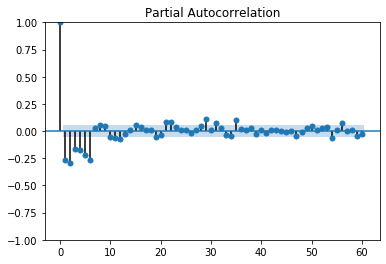

In [7]:
#checjing for lags' acf and pacf significance
# p = 1 to 7
# d = 1 to 2
# q = 1 
# m = 7 as we have found weekly seasonality effect
# P, D, Q we will try between 0 and 1

plot_acf(df["n_rides"],lags=60);
plot_pacf(df,lags=60);

In [8]:
#all possible parameters
p = [i for i in range(1,8)]
d = [1]
q = [1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7]

### Approach one
Use all combinations of the parameters picked to fit SARIMA and return one that shown best result on MSE versus test 

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 16023700.740769207
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 15688393.25918631
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
((1, 1, 1), (1, 0, 0, 7)) 13933089.86802705
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
((1, 1, 2), (1, 0, 0, 7)) 13167014.743165346
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 1, 7))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 1, 7))
i ((2, 1, 1), (1, 1, 0, 7))
i ((2, 1, 1), (1, 1, 1, 7))
i ((2, 1, 2), (0, 0, 0, 7))
i ((2, 1, 2), (0, 0, 1, 7))
i ((2, 1, 2), (0, 1, 0, 7)

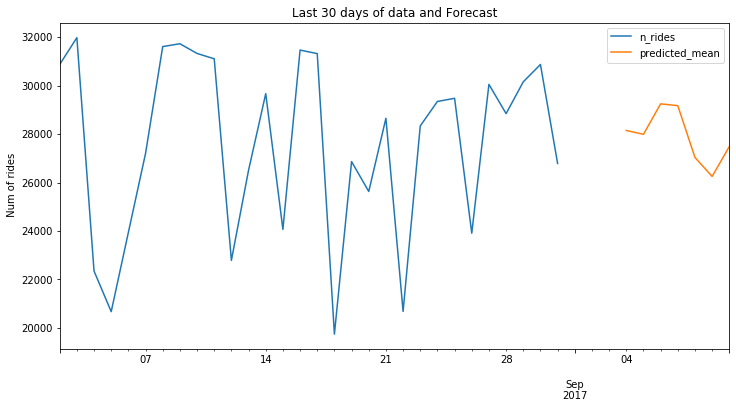

In [9]:
df= fm.get_data_ex_two()
best_rusults = fm.evaluate_and_return_best_forecast(SARIMAX, df, (p,d,q,P,D,Q,m), 2)
fm.plot_forecast(df,best_rusults)

### Approach two
Use all combinations of the parameters picked to fit SARIMAX 
Use month as exog feature to help to accouunt for monthly difference (tried to include flag on empty data but no success)
Return one that shown best result on MSE versus test 

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 16019664.642922295
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 15678591.08602327
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (1, 0, 0, 7))
((1, 1, 1), (1, 0, 0, 7)) 13934041.237744618
i ((1, 1, 1), (1, 0, 1, 7))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (1, 0, 0, 7))
((1, 1, 2), (1, 0, 0, 7)) 13170408.28423995
i ((1, 1, 2), (1, 0, 1, 7))
i ((1, 1, 2), (1, 1, 0, 7))
i ((1, 1, 2), (1, 1, 1, 7))
i ((2, 1, 1), (0, 0, 0, 7))
i ((2, 1, 1), (0, 0, 1, 7))
i ((2, 1, 1), (0, 1, 0, 7))
i ((2, 1, 1), (0, 1, 1, 7))
i ((2, 1, 1), (1, 0, 0, 7))
i ((2, 1, 1), (1, 0, 1, 7))
i ((2, 1, 1), (1, 1, 0, 7))
i ((2, 1, 1), (1, 1, 1, 7))
i ((2, 1, 2), (0, 0, 0, 7))
i ((2, 1, 2), (0, 0, 1, 7))
i ((2, 1, 2), (0, 1, 0, 7)

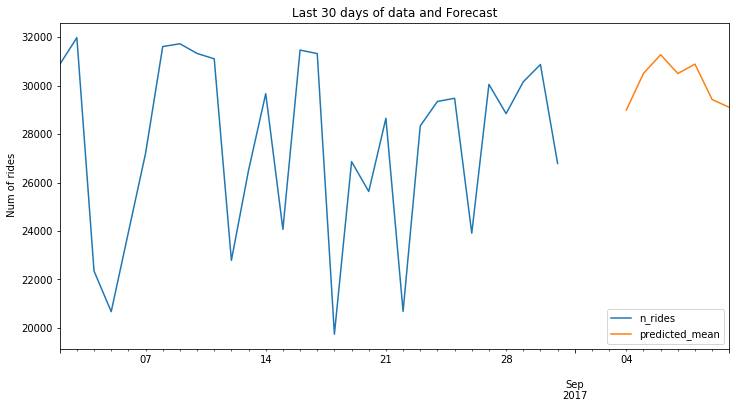

In [10]:
fm = ForecastMaker()
df= fm.get_data_ex_two()
months = df.index.month
best_rusults_exog = fm.evaluate_and_return_best_forecast(SARIMAX, df, (p,d,q,P,D,Q,m), 2, exog = months)
fm.plot_forecast(df,best_rusults_exog)


### Approach three  (PROVED TO FIT BEST)

Since we know that there is a yearly seasonality but using m=365 is not feasible I trimmed data to only August and September. Now we can try to capture yearly seasonality with m=61 (computing power should be able to mamange this). Plus since we are only interested in forecasting into begining of September focusing on these two months and removing months with empty data may help to capture the patterns better  

Use all combinations of the parameters picked to fit SARIMA

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7, 61])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 15127509.188387934
i ((1, 1, 1), (0, 0, 0, 61))
i ((1, 1, 1), (0, 0, 1, 7))
i ((1, 1, 1), (0, 0, 1, 61))
((1, 1, 1), (0, 0, 1, 61)) 14975173.264430968
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 0, 61))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (0, 1, 1, 61))
i ((1, 1, 1), (1, 0, 0, 7))
((1, 1, 1), (1, 0, 0, 7)) 14620790.132482242
i ((1, 1, 1), (1, 0, 0, 61))
i ((1, 1, 1), (1, 0, 1, 7))
((1, 1, 1), (1, 0, 1, 7)) 12824244.885016942
i ((1, 1, 1), (1, 0, 1, 61))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 0, 61))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 1), (1, 1, 1, 61))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 0, 61))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 0, 1, 61))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 0, 61))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (0, 1, 1, 61))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 0, 61))
i ((1,

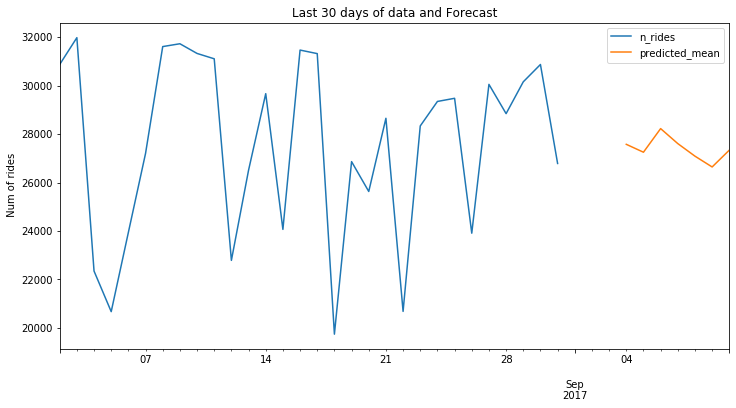

In [3]:
p = [i for i in range(1,8)]
d = [1]
q = [1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7,61]
fm = ForecastMaker()

df= fm.get_data_ex_two(True)
best_results_special = fm.evaluate_and_return_best_forecast(SARIMAX, df, (p,d,q,P,D,Q,m),2)
fm.plot_forecast(df,best_results_special)


In [5]:
best_results_special

{'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAX at 0x19c8eb8cb88>,
 'best_mse': 10899843.42205799,
 'best_forecast': 2017-09-04    27576.018838
 2017-09-05    27249.936225
 2017-09-06    28224.674555
 2017-09-07    27606.064089
 2017-09-08    27087.487960
 2017-09-09    26641.752413
 2017-09-10    27335.482362
 Name: predicted_mean, dtype: float64}

### Approach four

We can see from previous approach that trimmed data results in better fit. Weakly is still a better seasonality pattern. However, we know that there is a difference in target variable if broken down by months. Following approach is to try to incorporate that information by submitting months data as exogenous variable

Use all combinations of the parameters picked to fit SARIMAX

7
([1, 2, 3, 4, 5, 6, 7], [1], [1, 2], [0, 1], [0, 1], [0, 1], [7, 61])
i ((1, 1, 1), (0, 0, 0, 7))
((1, 1, 1), (0, 0, 0, 7)) 14468381.252132254
i ((1, 1, 1), (0, 0, 0, 61))
i ((1, 1, 1), (0, 0, 1, 7))
((1, 1, 1), (0, 0, 1, 7)) 14147741.610286267
i ((1, 1, 1), (0, 0, 1, 61))
i ((1, 1, 1), (0, 1, 0, 7))
i ((1, 1, 1), (0, 1, 0, 61))
i ((1, 1, 1), (0, 1, 1, 7))
i ((1, 1, 1), (0, 1, 1, 61))
i ((1, 1, 1), (1, 0, 0, 7))
((1, 1, 1), (1, 0, 0, 7)) 13818712.852481307
i ((1, 1, 1), (1, 0, 0, 61))
i ((1, 1, 1), (1, 0, 1, 7))
((1, 1, 1), (1, 0, 1, 7)) 12830518.844615366
i ((1, 1, 1), (1, 0, 1, 61))
i ((1, 1, 1), (1, 1, 0, 7))
i ((1, 1, 1), (1, 1, 0, 61))
i ((1, 1, 1), (1, 1, 1, 7))
i ((1, 1, 1), (1, 1, 1, 61))
i ((1, 1, 2), (0, 0, 0, 7))
i ((1, 1, 2), (0, 0, 0, 61))
i ((1, 1, 2), (0, 0, 1, 7))
i ((1, 1, 2), (0, 0, 1, 61))
i ((1, 1, 2), (0, 1, 0, 7))
i ((1, 1, 2), (0, 1, 0, 61))
i ((1, 1, 2), (0, 1, 1, 7))
i ((1, 1, 2), (0, 1, 1, 61))
i ((1, 1, 2), (1, 0, 0, 7))
i ((1, 1, 2), (1, 0, 0, 61))
i ((1, 

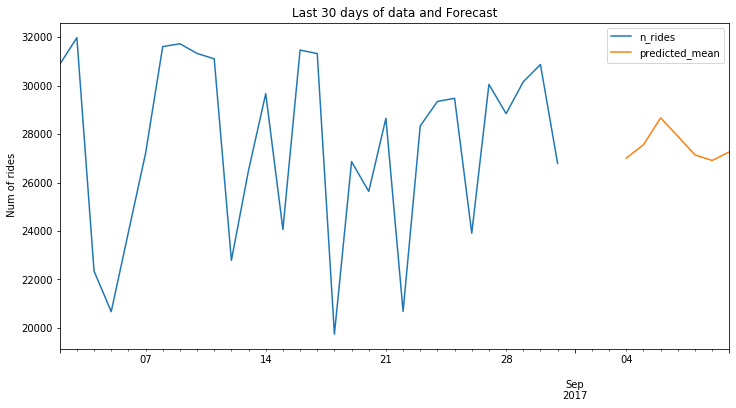

In [4]:
#all possible parameters
p = [i for i in range(1,8)]
d = [1]
q = [1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = [7,61]
fm = ForecastMaker()

df= fm.get_data_ex_two(True)
months = df.index.month
best_results_special_exog = fm.evaluate_and_return_best_forecast(SARIMAX, df, (p,d,q,P,D,Q,m),2, exog = months)
fm.plot_forecast(df,best_results_special_exog)